In [1]:
import pandas
import seaborn
import time

from lib.compiler import Compiler
from lib.models.generic_v0.model import mappable_params

from lib.models.aft20barzur import BitcoinSM as AFT20BarZur
from lib.models.fc16sapirshtein import BitcoinSM as FC16Sapirshtein

from lib.models.generic_v1 import protocols as g1
from lib.models.generic_v1.model import SingleAgent as G1Model

from lib.models.generic_v0.bitcoin import Bitcoin as G0Bitcoin
from lib.models.generic_v0.model import SelfishMining as G0Model

In [2]:
network = mappable_params

models = []
implicit_mdps = []


def add_model(*, implicit_mdp, **model):
    models.append(model)
    implicit_mdps.append(implicit_mdp)


# related work baseline


def _():
    pass

    add_model(
        scenario="reference",
        model="fc16sapirshtein",
        force_consider_own=True,
        merge_isomorphic=True,
        truncate_common_chain=True,
        collect_garbage=True,
        reward_common_chain=True,
        protocol="bitcoin",
        implicit_mdp=lambda c: FC16Sapirshtein(
            **network, maximum_fork_length=c
        ),  # TODO implement DAG size cutoff for this model
    )

    add_model(
        scenario="reference-v0",
        model="generic_0",
        force_consider_own=True,
        merge_isomorphic=True,
        truncate_common_chain=True,
        collect_garbage=True,
        reward_common_chain=True,
        protocol="bitcoin",
        implicit_mdp=lambda c: G0Model(
            G0Bitcoin(),
            **network,
            maximum_size=c,
            force_consider_own=True,
            merge_isomorphic=True,
        ),
    )


# our baseline: garbage collection + common chain truncation
# we want to compare to:
# - no common chain truncation (all infinite)
# - no garbage collection (infinite for protocols that allow stale blocks)
# - plus force-consider-own
# - plus merge-isomorphic
# - plus both


def add_scenario(
    scenario,
    *,
    collect_garbage=True,
    truncate_common_chain=True,
    force_consider_own=False,
    merge_isomorphic=False,
):
    def f(protocol_s, protocol_C, **protocol_args):
        model_args = dict(
            force_consider_own=force_consider_own,
            merge_isomorphic=merge_isomorphic,
            truncate_common_chain=truncate_common_chain,
            collect_garbage=collect_garbage,
            reward_common_chain=False,
        )
        add_model(
            scenario=scenario,
            model="generic_1",
            protocol=protocol_s,
            **model_args,
            implicit_mdp=lambda c: G1Model(
                protocol_C,
                **protocol_args,
                **network,
                **model_args,
                dag_size_cutoff=c,
            ),
        )

    f("bitcoin", g1.Bitcoin)
    f("ethereum_3", g1.Ethereum, h=3)
    f("byzantium_3", g1.Byzantium, h=3)
    f("ghostdag_3", g1.Ghostdag, k=3)
    f("parallel_3", g1.Parallel, k=3)


add_scenario("baseline")
add_scenario("w/o collect garbage", collect_garbage=False)
add_scenario("w/o truncate", truncate_common_chain=False)
add_scenario("w/ force consider", force_consider_own=True)
add_scenario("w/ normalization", merge_isomorphic=True)
add_scenario("w/ both", force_consider_own=True, merge_isomorphic=True)

models = pandas.DataFrame(models)
models

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain
0,baseline,generic_1,bitcoin,False,False,True,True,False
1,baseline,generic_1,ethereum_3,False,False,True,True,False
2,baseline,generic_1,byzantium_3,False,False,True,True,False
3,baseline,generic_1,ghostdag_3,False,False,True,True,False
4,baseline,generic_1,parallel_3,False,False,True,True,False
5,w/o collect garbage,generic_1,bitcoin,False,False,True,False,False
6,w/o collect garbage,generic_1,ethereum_3,False,False,True,False,False
7,w/o collect garbage,generic_1,byzantium_3,False,False,True,False,False
8,w/o collect garbage,generic_1,ghostdag_3,False,False,True,False,False
9,w/o collect garbage,generic_1,parallel_3,False,False,True,False,False


In [3]:
!mkdir -p 5-generated-mdps

In [4]:
from IPython.display import display, clear_output
import gc
import psutil
import pickle
import gzip

max_size = 100000
# max_size = 10000
aborts = []
size_log = []


def get_rss():
    gc.collect()
    return psutil.Process().memory_info().rss / 1024**3  # GiB


for idx, row in models.iterrows():
    dag_size_limit = 1
    while True:
        dag_size_limit += 1
        m = implicit_mdps[idx](dag_size_limit)
        c = Compiler(m)
        start_time = time.monotonic()
        while not_done := c.explore(steps=1000):
            if c.n_states > max_size:
                break

        info = row.to_dict() | dict(
            dag_size_limit=dag_size_limit,
            size=c.n_states,
            time_spent=time.monotonic() - start_time,
            rss=get_rss(),
        )

        # report to stdout
        print(
            "\r"
            + "\t".join(
                [
                    f"{k}: {info[k]}"
                    for k in [
                        "scenario",
                        "protocol",
                        "dag_size_limit",
                        "size",
                        "time_spent",
                        "rss",
                    ]
                ]
                + [f"abort: {not_done}                      "]
            ),
            end="",
        )

        if not_done:
            aborts.append(info)
            break
        else:
            mdp_key = format(abs(hash(frozenset(info.items()))), "08x")[0:8]
            size_log.append(info | dict(mdp=mdp_key))
            with gzip.open(f"5-generated-mdps/mdp-{mdp_key}.pkl.gz", "wb") as f:
                pickle.dump(c.mdp(finish_exploration=False), f)

size_log = pandas.DataFrame(size_log)
aborts = pandas.DataFrame(aborts)

size_log.to_pickle("5-generated-mdps/success.pkl.gz")
aborts.to_pickle("5-generated-mdps/fail.pkl.gz")

scenario: baseline	protocol: bitcoin	dag_size_limit: 2	size: 7	time_spent: 0.001939254999797413	rss: 0.17258834838867188	abort: False                      

scenario: baseline	protocol: bitcoin	dag_size_limit: 3	size: 65	time_spent: 0.013747831999808113	rss: 0.17307662963867188	abort: False                      

scenario: baseline	protocol: bitcoin	dag_size_limit: 4	size: 860	time_spent: 0.24189652299992304	rss: 0.17881393432617188	abort: False                      

scenario: baseline	protocol: bitcoin	dag_size_limit: 5	size: 10870	time_spent: 5.265134198999931	rss: 0.2516899108886719	abort: False                      

scenario: baseline	protocol: bitcoin	dag_size_limit: 6	size: 100433	time_spent: 56.03250101799995	rss: 0.9779930114746094	abort: True                      

scenario: baseline	protocol: ethereum_3	dag_size_limit: 3	size: 65	time_spent: 0.015346468999723584	rss: 0.21448135375976562	abort: False                      

scenario: baseline	protocol: ethereum_3	dag_size_limit: 4	size: 872	time_spent: 0.2756571410000106	rss: 0.21399307250976562	abort: False                      

scenario: baseline	protocol: ethereum_3	dag_size_limit: 5	size: 11876	time_spent: 6.134110527999837	rss: 0.26496124267578125	abort: False                      

scenario: baseline	protocol: ethereum_3	dag_size_limit: 6	size: 100318	time_spent: 59.71341416300038	rss: 0.9622268676757812	abort: True                      

scenario: baseline	protocol: byzantium_3	dag_size_limit: 3	size: 65	time_spent: 0.016211460999784322	rss: 0.21387863159179688	abort: False                      

scenario: baseline	protocol: byzantium_3	dag_size_limit: 4	size: 872	time_spent: 0.28787336200002756	rss: 0.21363449096679688	abort: False                      

scenario: baseline	protocol: byzantium_3	dag_size_limit: 5	size: 11876	time_spent: 6.450768801999857	rss: 0.2597770690917969	abort: False                      

scenario: baseline	protocol: byzantium_3	dag_size_limit: 6	size: 100285	time_spent: 62.03004643500026	rss: 0.9621696472167969	abort: True                      

scenario: baseline	protocol: ghostdag_3	dag_size_limit: 3	size: 55	time_spent: 0.014070446999994601	rss: 0.21619796752929688	abort: False                      

scenario: baseline	protocol: ghostdag_3	dag_size_limit: 4	size: 710	time_spent: 0.25220536699998775	rss: 0.21570968627929688	abort: False                      

scenario: baseline	protocol: ghostdag_3	dag_size_limit: 5	size: 10573	time_spent: 6.447067213000082	rss: 0.24618148803710938	abort: False                      

scenario: baseline	protocol: ghostdag_3	dag_size_limit: 6	size: 100575	time_spent: 70.31551363800008	rss: 0.9211082458496094	abort: True                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 3	size: 55	time_spent: 0.01260937200004264	rss: 0.21718978881835938	abort: False                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 4	size: 439	time_spent: 0.14506112500021118	rss: 0.21645736694335938	abort: False                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 5	size: 3637	time_spent: 1.929492861000199	rss: 0.21621322631835938	abort: False                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 6	size: 34664	time_spent: 22.241042648000075	rss: 0.4678001403808594	abort: False                      

scenario: baseline	protocol: parallel_3	dag_size_limit: 7	size: 100617	time_spent: 64.72100534699985	rss: 1.065643310546875	abort: True                      

scenario: w/o collect garbage	protocol: bitcoin	dag_size_limit: 3	size: 65	time_spent: 0.009679926999979216	rss: 0.230804443359375	abort: False                      

scenario: w/o collect garbage	protocol: bitcoin	dag_size_limit: 4	size: 916	time_spent: 0.16799652500003504	rss: 0.230316162109375	abort: False                      

scenario: w/o collect garbage	protocol: bitcoin	dag_size_limit: 5	size: 13778	time_spent: 4.4772725400002855	rss: 0.283172607421875	abort: False                      

scenario: w/o collect garbage	protocol: bitcoin	dag_size_limit: 6	size: 100332	time_spent: 34.39224006299992	rss: 0.944793701171875	abort: True                      

scenario: w/o collect garbage	protocol: ethereum_3	dag_size_limit: 3	size: 65	time_spent: 0.010115513999608083	rss: 0.23330307006835938	abort: False                      

scenario: w/o collect garbage	protocol: ethereum_3	dag_size_limit: 4	size: 916	time_spent: 0.17778601800000615	rss: 0.23305892944335938	abort: False                      

scenario: w/o collect garbage	protocol: ethereum_3	dag_size_limit: 5	size: 14060	time_spent: 4.636716842999704	rss: 0.2851829528808594	abort: False                      

scenario: w/o collect garbage	protocol: ethereum_3	dag_size_limit: 6	size: 101058	time_spent: 36.4894994780002	rss: 0.9475364685058594	abort: True                      

scenario: w/o collect garbage	protocol: byzantium_3	dag_size_limit: 3	size: 65	time_spent: 0.010770215999855282	rss: 0.23543548583984375	abort: False                      

scenario: w/o collect garbage	protocol: byzantium_3	dag_size_limit: 4	size: 916	time_spent: 0.1931220060000669	rss: 0.23494720458984375	abort: False                      

scenario: w/o collect garbage	protocol: byzantium_3	dag_size_limit: 5	size: 14060	time_spent: 5.013089115000184	rss: 0.2852516174316406	abort: False                      

scenario: w/o collect garbage	protocol: byzantium_3	dag_size_limit: 6	size: 101034	time_spent: 39.4614480780001	rss: 0.9469947814941406	abort: True                      

scenario: w/o collect garbage	protocol: ghostdag_3	dag_size_limit: 3	size: 55	time_spent: 0.010248565999972925	rss: 0.2328338623046875	abort: False                      

scenario: w/o collect garbage	protocol: ghostdag_3	dag_size_limit: 4	size: 710	time_spent: 0.19272825699999885	rss: 0.2327117919921875	abort: False                      

scenario: w/o collect garbage	protocol: ghostdag_3	dag_size_limit: 5	size: 11260	time_spent: 5.389015581999956	rss: 0.26153564453125	abort: False                      

scenario: w/o collect garbage	protocol: ghostdag_3	dag_size_limit: 6	size: 100135	time_spent: 54.22666875699997	rss: 0.90142822265625	abort: True                      

scenario: w/o collect garbage	protocol: parallel_3	dag_size_limit: 3	size: 55	time_spent: 0.008531128999948123	rss: 0.23769378662109375	abort: False                      

scenario: w/o collect garbage	protocol: parallel_3	dag_size_limit: 4	size: 439	time_spent: 0.09232829499978834	rss: 0.23679351806640625	abort: False                      

scenario: w/o collect garbage	protocol: parallel_3	dag_size_limit: 5	size: 3637	time_spent: 1.2011921680000341	rss: 0.23614501953125	abort: False                      

scenario: w/o collect garbage	protocol: parallel_3	dag_size_limit: 6	size: 34664	time_spent: 15.204678264999984	rss: 0.47113037109375	abort: False                      

scenario: w/o collect garbage	protocol: parallel_3	dag_size_limit: 7	size: 101113	time_spent: 45.67323949299998	rss: 1.0617218017578125	abort: True                      

scenario: w/o truncate	protocol: bitcoin	dag_size_limit: 3	size: 77	time_spent: 0.014306771000065055	rss: 0.24279403686523438	abort: False                      

scenario: w/o truncate	protocol: bitcoin	dag_size_limit: 4	size: 1012	time_spent: 0.3252029640002547	rss: 0.2416229248046875	abort: False                      

scenario: w/o truncate	protocol: bitcoin	dag_size_limit: 5	size: 12892	time_spent: 5.592141907000041	rss: 0.2783660888671875	abort: False                      

scenario: w/o truncate	protocol: bitcoin	dag_size_limit: 6	size: 100016	time_spent: 51.87938928799986	rss: 0.9582977294921875	abort: True                      

scenario: w/o truncate	protocol: ethereum_3	dag_size_limit: 3	size: 77	time_spent: 0.016869727000084822	rss: 0.24472808837890625	abort: False                      

scenario: w/o truncate	protocol: ethereum_3	dag_size_limit: 4	size: 1024	time_spent: 0.295501306999995	rss: 0.24408340454101562	abort: False                      

scenario: w/o truncate	protocol: ethereum_3	dag_size_limit: 5	size: 13922	time_spent: 6.631892624000102	rss: 0.2854652404785156	abort: False                      

scenario: w/o truncate	protocol: ethereum_3	dag_size_limit: 6	size: 101411	time_spent: 55.27416984799993	rss: 0.9579505920410156	abort: True                      

scenario: w/o truncate	protocol: byzantium_3	dag_size_limit: 3	size: 77	time_spent: 0.01738199600004009	rss: 0.24557876586914062	abort: False                      

scenario: w/o truncate	protocol: byzantium_3	dag_size_limit: 4	size: 1024	time_spent: 0.4110165170000073	rss: 0.24484634399414062	abort: False                      

scenario: w/o truncate	protocol: byzantium_3	dag_size_limit: 5	size: 13922	time_spent: 7.077445420000004	rss: 0.2856178283691406	abort: False                      

scenario: w/o truncate	protocol: byzantium_3	dag_size_limit: 6	size: 101384	time_spent: 58.61860233900006	rss: 0.9579811096191406	abort: True                      

scenario: w/o truncate	protocol: ghostdag_3	dag_size_limit: 3	size: 67	time_spent: 0.013795584000035888	rss: 0.24473953247070312	abort: False                      

scenario: w/o truncate	protocol: ghostdag_3	dag_size_limit: 4	size: 842	time_spent: 0.24990693899962935	rss: 0.24473953247070312	abort: False                      

scenario: w/o truncate	protocol: ghostdag_3	dag_size_limit: 5	size: 12291	time_spent: 5.958618254000157	rss: 0.2689094543457031	abort: False                      

scenario: w/o truncate	protocol: ghostdag_3	dag_size_limit: 6	size: 100134	time_spent: 54.118754206000176	rss: 0.9080696105957031	abort: True                      

scenario: w/o truncate	protocol: parallel_3	dag_size_limit: 3	size: 55	time_spent: 0.012411905999670125	rss: 0.24960708618164062	abort: False                      

scenario: w/o truncate	protocol: parallel_3	dag_size_limit: 4	size: 439	time_spent: 0.13973989199985226	rss: 0.24863052368164062	abort: False                      

scenario: w/o truncate	protocol: parallel_3	dag_size_limit: 5	size: 3637	time_spent: 1.8379634479997549	rss: 0.24863052368164062	abort: False                      

scenario: w/o truncate	protocol: parallel_3	dag_size_limit: 6	size: 34760	time_spent: 21.927686410000206	rss: 0.4755706787109375	abort: False                      

scenario: w/o truncate	protocol: parallel_3	dag_size_limit: 7	size: 100645	time_spent: 66.5418717309999	rss: 1.0657005310058594	abort: True                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 4	size: 74	time_spent: 0.018938920999971742	rss: 0.24384307861328125	abort: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 5	size: 236	time_spent: 0.08013258499977383	rss: 0.24335479736328125	abort: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 6	size: 806	time_spent: 0.31966379000004963	rss: 0.24311065673828125	abort: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 7	size: 2519	time_spent: 1.3837215579997064	rss: 0.24311065673828125	abort: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 8	size: 8188	time_spent: 5.134968019000098	rss: 0.2597236633300781	abort: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 9	size: 26225	time_spent: 18.779652523000095	rss: 0.4449043273925781	abort: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 10	size: 85078	time_spent: 69.16256851399976	rss: 1.0823554992675781	abort: False                      

scenario: w/ force consider	protocol: bitcoin	dag_size_limit: 11	size: 100626	time_spent: 85.90294473499944	rss: 1.2602272033691406	abort: True                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 4	size: 79	time_spent: 0.021768110999801138	rss: 0.24739456176757812	abort: False                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 5	size: 291	time_spent: 0.10441992200048844	rss: 0.24690628051757812	abort: False                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 6	size: 1193	time_spent: 0.5607385869998325	rss: 0.24666213989257812	abort: False                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 7	size: 4715	time_spent: 2.5322920979997434	rss: 0.24641799926757812	abort: False                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 8	size: 19462	time_spent: 12.061309319999964	rss: 0.3610420227050781	abort: False                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 9	size: 74090	time_spent: 53.99122213800001	rss: 0.9049873352050781	abort: False                      

scenario: w/ force consider	protocol: ethereum_3	dag_size_limit: 10	size: 100202	time_spent: 81.42071472299995	rss: 1.1954269409179688	abort: True                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 4	size: 79	time_spent: 0.02398490900031902	rss: 0.24989700317382812	abort: False                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 5	size: 291	time_spent: 0.11278273700008867	rss: 0.24989700317382812	abort: False                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 6	size: 1193	time_spent: 0.597684518999813	rss: 0.24989700317382812	abort: False                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 7	size: 4666	time_spent: 2.7645698140004242	rss: 0.24965286254882812	abort: False                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 8	size: 19215	time_spent: 13.131360933999531	rss: 0.3587837219238281	abort: False                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 9	size: 74359	time_spent: 59.67068346199994	rss: 0.9082221984863281	abort: False                      

scenario: w/ force consider	protocol: byzantium_3	dag_size_limit: 10	size: 100048	time_spent: 89.50013812299949	rss: 1.1927566528320312	abort: True                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 4	size: 82	time_spent: 0.02403291500013438	rss: 0.2539176940917969	abort: False                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 5	size: 336	time_spent: 0.14149713299957511	rss: 0.2536735534667969	abort: False                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 6	size: 1631	time_spent: 0.9367122920002657	rss: 0.2534294128417969	abort: False                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 7	size: 7153	time_spent: 5.6197952769998665	rss: 0.2513465881347656	abort: False                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 8	size: 35292	time_spent: 35.44895971099959	rss: 0.4891395568847656	abort: False                      

scenario: w/ force consider	protocol: ghostdag_3	dag_size_limit: 9	size: 100019	time_spent: 125.70906955100054	rss: 1.1126747131347656	abort: True                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 4	size: 125	time_spent: 0.03046574900054111	rss: 0.2638816833496094	abort: False                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 5	size: 643	time_spent: 0.19134595600007742	rss: 0.2631492614746094	abort: False                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 6	size: 3433	time_spent: 1.3732895829998597	rss: 0.2630271911621094	abort: False                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 7	size: 18038	time_spent: 9.298027750000074	rss: 0.3509178161621094	abort: False                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 8	size: 81832	time_spent: 49.54119797899966	rss: 0.9733543395996094	abort: False                      

scenario: w/ force consider	protocol: parallel_3	dag_size_limit: 9	size: 101077	time_spent: 70.28415840200068	rss: 1.1908836364746094	abort: True                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 3	size: 56	time_spent: 0.017584903000170016	rss: 0.2693901062011719	abort: False                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 4	size: 444	time_spent: 0.19231325199962157	rss: 0.2691459655761719	abort: False                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 5	size: 3006	time_spent: 1.9465343770007166	rss: 0.2687416076660156	abort: False                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 6	size: 19474	time_spent: 17.520435784000256	rss: 0.3414955139160156	abort: False                      

scenario: w/ normalization	protocol: bitcoin	dag_size_limit: 7	size: 100475	time_spent: 101.05946067900004	rss: 1.0625648498535156	abort: True                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 3	size: 56	time_spent: 0.019336698000188335	rss: 0.2781944274902344	abort: False                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 4	size: 453	time_spent: 0.21221161800076516	rss: 0.2772178649902344	abort: False                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 5	size: 3438	time_spent: 2.2925160389995654	rss: 0.2769737243652344	abort: False                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 6	size: 28298	time_spent: 23.78885792300025	rss: 0.4143028259277344	abort: False                      

scenario: w/ normalization	protocol: ethereum_3	dag_size_limit: 7	size: 101617	time_spent: 94.51607794300071	rss: 1.0394248962402344	abort: True                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 3	size: 56	time_spent: 0.019686175999595434	rss: 0.28020477294921875	abort: False                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 4	size: 453	time_spent: 0.21672782999939955	rss: 0.2798118591308594	abort: False                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 5	size: 3438	time_spent: 2.3768074900008287	rss: 0.2798118591308594	abort: False                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 6	size: 28102	time_spent: 24.634366567999677	rss: 0.4159202575683594	abort: False                      

scenario: w/ normalization	protocol: byzantium_3	dag_size_limit: 7	size: 101157	time_spent: 98.05435242300064	rss: 1.0360374450683594	abort: True                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 3	size: 49	time_spent: 0.017635858000176086	rss: 0.28122711181640625	abort: False                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 4	size: 381	time_spent: 0.18901308699969377	rss: 0.28049468994140625	abort: False                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 5	size: 3360	time_spent: 2.4297537049997118	rss: 0.28061676025390625	abort: False                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 6	size: 33624	time_spent: 33.815488021999954	rss: 0.445953369140625	abort: False                      

scenario: w/ normalization	protocol: ghostdag_3	dag_size_limit: 7	size: 101478	time_spent: 106.57786386000043	rss: 0.997344970703125	abort: True                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 3	size: 49	time_spent: 0.01676684500034753	rss: 0.28588104248046875	abort: False                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 4	size: 221	time_spent: 0.11390413899971463	rss: 0.28490447998046875	abort: False                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 5	size: 800	time_spent: 0.5591322130003391	rss: 0.28466033935546875	abort: False                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 6	size: 3138	time_spent: 2.8096520689996396	rss: 0.28368377685546875	abort: False                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 7	size: 15800	time_spent: 14.867851269999846	rss: 0.33458709716796875	abort: False                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 8	size: 98049	time_spent: 105.20649444799983	rss: 1.1374435424804688	abort: False                      

scenario: w/ normalization	protocol: parallel_3	dag_size_limit: 9	size: 101181	time_spent: 119.98422585300068	rss: 1.2211112976074219	abort: True                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 4	size: 56	time_spent: 0.02297589599947969	rss: 0.2755470275878906	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 5	size: 156	time_spent: 0.08053028499944048	rss: 0.2740821838378906	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 6	size: 425	time_spent: 0.2542547310004011	rss: 0.2740821838378906	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 7	size: 1139	time_spent: 0.8725145140006134	rss: 0.2738380432128906	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 8	size: 3103	time_spent: 2.7856369139999515	rss: 0.2738380432128906	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 9	size: 8554	time_spent: 8.594908447000307	rss: 0.2726173400878906	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 10	size: 23826	time_spent: 27.90649063700039	rss: 0.4347267150878906	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 11	size: 66749	time_spent: 88.74987792799948	rss: 0.9222755432128906	abort: False                      

scenario: w/ both	protocol: bitcoin	dag_size_limit: 12	size: 100847	time_spent: 138.90766246400017	rss: 1.3352775573730469	abort: True                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 4	size: 60	time_spent: 0.0257283089995326	rss: 0.2801971435546875	abort: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 5	size: 195	time_spent: 0.10183585400045558	rss: 0.2787322998046875	abort: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 6	size: 642	time_spent: 0.38019988399992144	rss: 0.2782440185546875	abort: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 7	size: 2101	time_spent: 1.6473358969997207	rss: 0.2783660888671875	abort: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 8	size: 6876	time_spent: 5.93018812199989	rss: 0.2781944274902344	abort: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 9	size: 21803	time_spent: 21.888239374000477	rss: 0.3981895446777344	abort: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 10	size: 68558	time_spent: 76.31031566799993	rss: 0.8919639587402344	abort: False                      

scenario: w/ both	protocol: ethereum_3	dag_size_limit: 11	size: 100040	time_spent: 128.22169440400012	rss: 1.2628288269042969	abort: True                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 4	size: 60	time_spent: 0.026883611999437562	rss: 0.2834434509277344	abort: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 5	size: 195	time_spent: 0.10873813000034716	rss: 0.2822227478027344	abort: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 6	size: 642	time_spent: 0.406325991999438	rss: 0.2819786071777344	abort: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 7	size: 2065	time_spent: 1.7131672229998003	rss: 0.2817344665527344	abort: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 8	size: 6615	time_spent: 6.174713338999936	rss: 0.2803916931152344	abort: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 9	size: 20769	time_spent: 22.58355465600016	rss: 0.3875694274902344	abort: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 10	size: 66065	time_spent: 79.4148684060001	rss: 0.8660850524902344	abort: False                      

scenario: w/ both	protocol: byzantium_3	dag_size_limit: 11	size: 100456	time_spent: 140.58517172200027	rss: 1.2487373352050781	abort: True                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 4	size: 58	time_spent: 0.025847664000139048	rss: 0.2868804931640625	abort: False                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 5	size: 196	time_spent: 0.11431537399948866	rss: 0.2863922119140625	abort: False                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 6	size: 668	time_spent: 0.48982062699997186	rss: 0.2863922119140625	abort: False                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 7	size: 2302	time_spent: 2.304397898999923	rss: 0.2861480712890625	abort: False                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 8	size: 8024	time_spent: 10.017307518000052	rss: 0.2845611572265625	abort: False                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 9	size: 28264	time_spent: 44.22292348500014	rss: 0.4481849670410156	abort: False                      

scenario: w/ both	protocol: ghostdag_3	dag_size_limit: 10	size: 100246	time_spent: 195.35137055999985	rss: 1.1809730529785156	abort: True                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 4	size: 79	time_spent: 0.032685819000107585	rss: 0.30011749267578125	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 5	size: 214	time_spent: 0.11716874800004007	rss: 0.29938507080078125	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 6	size: 591	time_spent: 0.36590766000063013	rss: 0.29938507080078125	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 7	size: 1777	time_spent: 1.321188255999914	rss: 0.29901885986328125	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 8	size: 5375	time_spent: 4.6413805470001535	rss: 0.2969017028808594	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 9	size: 15212	time_spent: 16.049217103000046	rss: 0.3469505310058594	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 10	size: 39154	time_spent: 49.235909865000394	rss: 0.6129417419433594	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 11	size: 96136	time_spent: 137.86662200400042	rss: 1.2737083435058594	abort: False                      

scenario: w/ both	protocol: parallel_3	dag_size_limit: 12	size: 100337	time_spent: 157.48168341699966	rss: 1.3729133605957031	abort: True                      

In [5]:
aborts

,scenario,model,protocol,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,reward_common_chain,dag_size_limit,size,time_spent,rss
0,baseline,generic_1,bitcoin,False,False,True,True,False,6,100433,56.032501,0.977993
1,baseline,generic_1,ethereum_3,False,False,True,True,False,6,100318,59.713414,0.962227
2,baseline,generic_1,byzantium_3,False,False,True,True,False,6,100285,62.030046,0.962170
3,baseline,generic_1,ghostdag_3,False,False,True,True,False,6,100575,70.315514,0.921108
4,baseline,generic_1,parallel_3,False,False,True,True,False,7,100617,64.721005,1.065643
5,w/o collect garbage,generic_1,bitcoin,False,False,True,False,False,6,100332,34.392240,0.944794
6,w/o collect garbage,generic_1,ethereum_3,False,False,True,False,False,6,101058,36.489499,0.947536
7,w/o collect garbage,generic_1,byzantium_3,False,False,True,False,False,6,101034,39.461448,0.946995
8,w/o collect garbage,generic_1,ghostdag_3,False,False,True,False,False,6,100135,54.226669,0.901428
9,w/o collect garbage,generic_1,parallel_3,False,False,True,False,False,7,101113,45.673239,1.061722


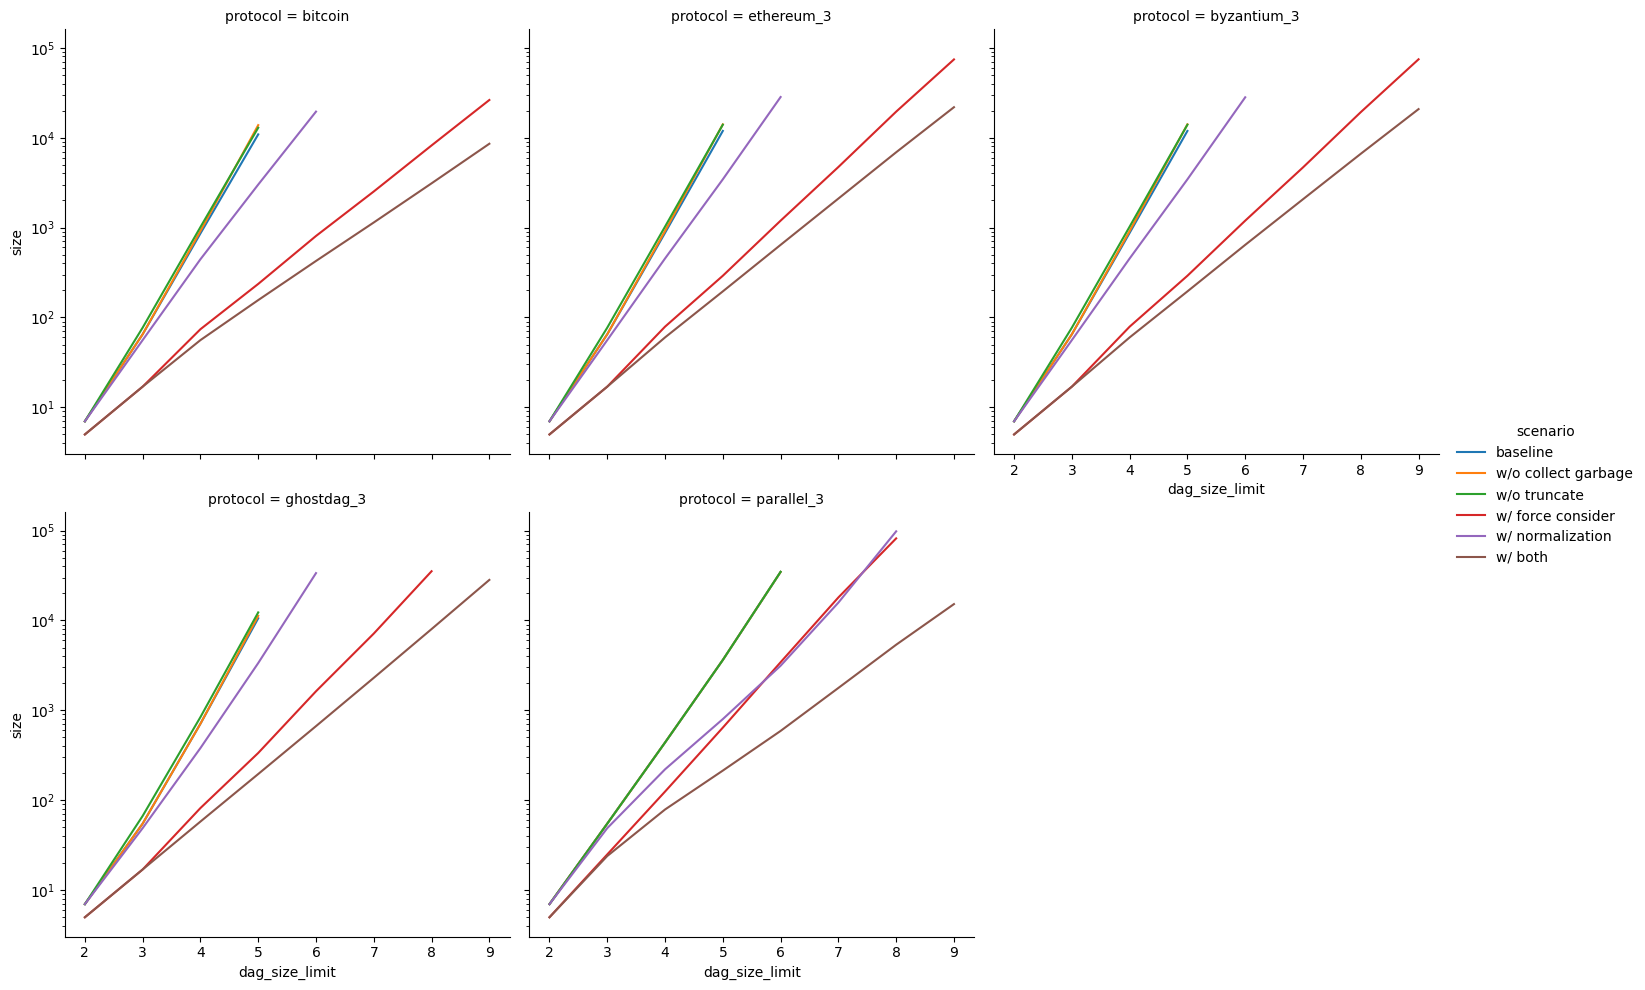

In [6]:
seaborn.relplot(
    data=size_log.query("dag_size_limit < 10"),
    kind="line",
    x="dag_size_limit",
    y="size",
    hue="scenario",
    col="protocol",
    col_wrap=3,
).set(yscale="log")